# Creating a Kaggle Workflow

In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing Data

In [24]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ["Age_categories","Fare_categories","Title", "Cabin_type", "Sex"]:
        df = create_dummies(df, col)
    return df

In [4]:
train = process_df(train)
holdout = process_df(holdout)
print(train.head, '\n')
print(holdout.head)

<bound method NDFrame.head of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                     

## Exploring the Data

In [5]:
explore = train[["SibSp", "Parch"]].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SibSp   891 non-null    int64
 1   Parch   891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

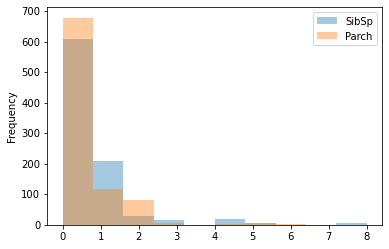

In [7]:
explore.plot.hist(alpha=0.4)
plt.legend()
plt.show()

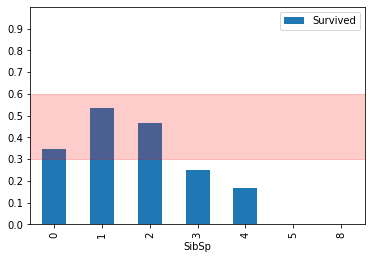

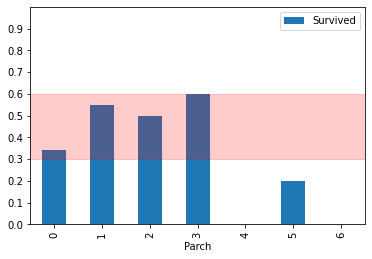

In [8]:
sibsp_pivot = train.pivot_table(index="SibSp",values="Survived")
sibsp_pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1))
plt.axhspan(.3, .6, alpha=0.2, color='red')

parch_pivot = train.pivot_table(index="Parch",values="Survived")
parch_pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1))
plt.axhspan(.3, .6, alpha=0.2, color='red')
plt.show()

<AxesSubplot:ylabel='Frequency'>

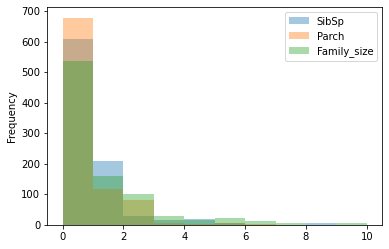

In [9]:
explore["Family_size"] = explore[["SibSp","Parch"]].sum(axis=1)
explore["Survived"] = train["Survived"]
# train["Family_size"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived", axis=1).plot.hist(alpha=0.4)

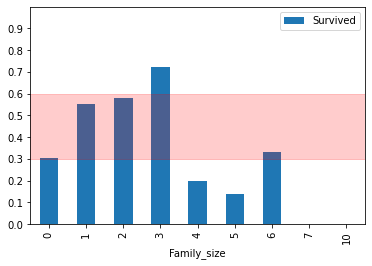

In [10]:
fam_pivot = explore.pivot_table(index="Family_size",values="Survived")
fam_pivot.plot.bar(ylim=(0,1), yticks=np.arange(0,1,0.1))
plt.axhspan(.3, .6, alpha=0.2, color='red')
plt.show()

In [11]:
def isalone(df):
    df["Family_size"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["Family_size"] == 0),"isalone"] = 1
    return df
train = isalone(train)
holdout = isalone(holdout)

In [12]:
train["isalone"].value_counts()

1    537
0    354
Name: isalone, dtype: int64

In [13]:
holdout["isalone"].value_counts()

1    253
0    165
Name: isalone, dtype: int64

## Selecting the Best-Performing Features

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(include='number')
    df = df.dropna(axis=1)
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    return best_columns

best_features = select_features(train)
best_features

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Young Adult',
 'Age_categories_Adult',
 'Fare_categories_0-12',
 'Fare_categories_12-50',
 'Fare_categories_50-100',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'Family_size']

## Selecting and Tuning Different Algorithms

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [16]:
def select_model(df, columns):
    all_X = df[columns]
    all_y = df["Survived"]
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    for model in models:
        print(model["name"])
        grid = GridSearchCV(estimator=model["estimator"], 
                            param_grid=model["hyperparameters"],
                           cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
        
    return models
    

In [17]:
result = select_model(train, best_features)

LogisticRegression


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

Best Score: 0.821598002496879
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
Best Score: 0.7834207240948814
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
Best Score: 0.8350686641697876
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}



## Making a Submission to Kaggle

In [19]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_estimator"]
save_submission_file(best_rf_model,best_features)

In [22]:
def save_submission_file(model, columns, file_name):
    predictions = model.predict(holdout[columns])
    submission = pd.DataFrame({
        "PassengerId": holdout["PassengerId"],
        "Survived": predictions
    })
    submission.to_csv(file_name, index=False)

    

In [23]:
best_model = result[2]["best_estimator"]
save_submission_file(best_model,best_features, 'submission_kaggle.csv')